# Automobile Fuel Efficiency Analysis

### Import Required Libraries and Load Dataset

We import:

• pandas, numpy for data manipulation  
• seaborn, matplotlib for visualization  
• sklearn for regression and regularization  
• statsmodels for influence diagnostics 

Dataset: Auto MPG  
Target Variable: mpg  
Type: Regression with Missing Data  

#### Aim

To build regression models to predict automobile fuel efficiency (MPG), 
handle missing horsepower values, detect influential observations, 
and analyze the impact of regularization.

In [1]:
import urllib.request

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
urllib.request.urlretrieve(url, "auto-mpg.data")

print("Dataset downloaded successfully!")

Dataset downloaded successfully!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# Column names
columns = ["mpg","cylinders","displacement","horsepower",
           "weight","acceleration","model_year","origin","car_name"]

# Load dataset
df = pd.read_csv("auto-mpg.data",
                 delim_whitespace=True,
                 names=columns,
                 na_values="?")

df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


### Exploratory Data Analysis

We examine:

• Summary statistics  
• Distribution of MPG  
• Relationship between weight and MPG  
• Correlation matrix  

This helps understand feature influence.

In [3]:
df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


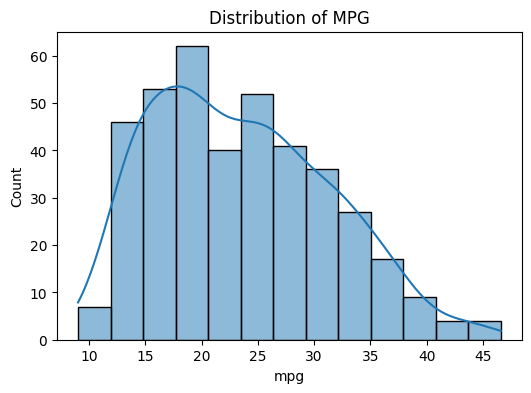

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(df["mpg"], kde=True)
plt.title("Distribution of MPG")
plt.show()

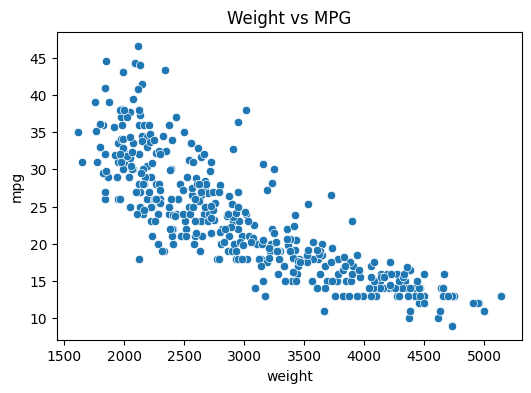

In [5]:
plt.figure(figsize=(6,4))
sns.scatterplot(x="weight", y="mpg", data=df)
plt.title("Weight vs MPG")
plt.show()

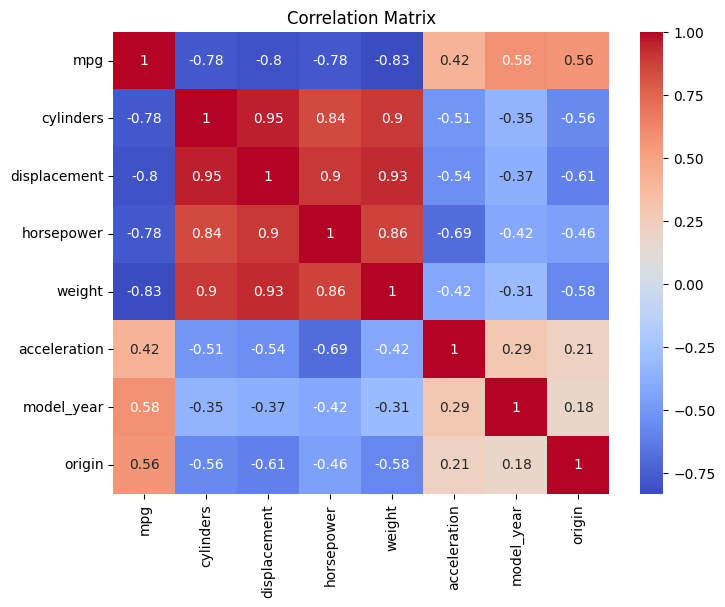

In [6]:
numeric_df = df.select_dtypes(include=["number"])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Missing Data Imputation

We apply two methods:

- Mean Imputation  
- Regression Imputation  

This allows comparison of imputation impact on model performance.

Regression imputation predicts missing horsepower using other variables.

In [7]:
# Mean Imputation
df_mean = df.copy()

mean_hp = df_mean["horsepower"].mean()
df_mean["horsepower"].fillna(mean_hp, inplace=True)

# Regression Imputation
df_reg = df.copy()
train_hp = df_reg[df_reg["horsepower"].notnull()]
test_hp = df_reg[df_reg["horsepower"].isnull()]

X_train_hp = train_hp.drop(["horsepower","car_name"], axis=1)
y_train_hp = train_hp["horsepower"]

model_hp = LinearRegression()
model_hp.fit(X_train_hp, y_train_hp)

X_missing = test_hp.drop(["horsepower","car_name"], axis=1)
predicted_hp = model_hp.predict(X_missing)

df_reg.loc[df_reg["horsepower"].isnull(), "horsepower"] = predicted_hp

### Outlier Detection

We use:

• Leverage values  
• Studentized residuals  

High leverage + large residual → influential point

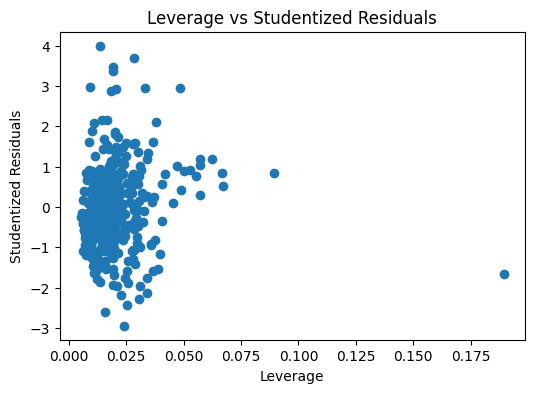

In [8]:
df_encoded = pd.get_dummies(df_reg.drop("car_name", axis=1), drop_first=True)
df_encoded = df_encoded.astype(float)

X_sm = sm.add_constant(df_encoded.drop("mpg", axis=1))
y_sm = df_encoded["mpg"]

model = sm.OLS(y_sm, X_sm).fit()

influence = model.get_influence()
leverage = influence.hat_matrix_diag
student_residuals = influence.resid_studentized_external

plt.figure(figsize=(6,4))
plt.scatter(leverage, student_residuals)
plt.xlabel("Leverage")
plt.ylabel("Studentized Residuals")
plt.title("Leverage vs Studentized Residuals")
plt.show()

### Model Comparison

We compare:

• Linear Regression  
• Ridge Regression  
• Lasso Regression  

In [10]:
X = df_reg.drop(["mpg","car_name"], axis=1)
y = df_reg["mpg"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Linear Regression
linear = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linear.fit(X_train, y_train)
y_pred_lin = linear.predict(X_test)

mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

mse_lin, r2_lin


(8.20508106026987, 0.8473940158954651)

In [11]:
# Ridge Regression
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_ridge, r2_ridge


(8.219579728216205, 0.8471243557331946)

In [12]:

# Lasso Regression
lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso())
])

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

mse_lasso, r2_lasso

(8.670786850154986, 0.8387323719888953)

### Grid Search with Cross Validation

We tune alpha for Ridge and Lasso using 5-fold CV.

In [13]:
param_grid = {"model__alpha": np.logspace(-3, 3, 20)}

ridge_gs = GridSearchCV(ridge, param_grid, cv=5)
ridge_gs.fit(X_train, y_train)

lasso_gs = GridSearchCV(lasso, param_grid, cv=5)
lasso_gs.fit(X_train, y_train)

ridge_gs.best_params_, lasso_gs.best_params_

({'model__alpha': np.float64(2.976351441631316)},
 {'model__alpha': np.float64(0.07847599703514611)})

### Regularization Path

We visualize how coefficients shrink as alpha increases.

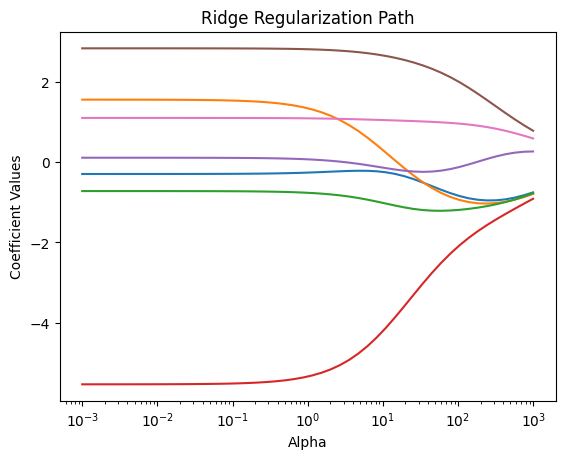

In [14]:
alphas = np.logspace(-3, 3, 50)
coefs = []

for a in alphas:
    ridge_temp = Ridge(alpha=a)
    ridge_temp.fit(StandardScaler().fit_transform(X_train), y_train)
    coefs.append(ridge_temp.coef_)

plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Coefficient Values")
plt.title("Ridge Regularization Path")
plt.show()

### Interpretation of Coefficients

- Weight shows strong negative relationship with MPG.

- Regularization shrinks coefficients to prevent overfitting.

- Lasso may zero-out less important variables.

- Ridge stabilizes correlated predictors.